#### [Exp_04] 프로젝트 : 주식 예측에 도전해 보자

In [1]:
import pandas
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.4.4
1.1.2
0.13.2


In [2]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


STEP 1 : 시계열 데이터 준비

In [3]:

# Time Series 생성
# dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
dataset_filepath = './data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

print(df.info())
ts.head()
# ts.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2021-09-30 to 2022-09-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       245 non-null    float64
 1   High       245 non-null    float64
 2   Low        245 non-null    float64
 3   Close      245 non-null    float64
 4   Adj Close  245 non-null    float64
 5   Volume     245 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.4 KB
None


Date
2021-09-30    74100.0
2021-10-01    73200.0
2021-10-05    72200.0
2021-10-06    71300.0
2021-10-07    71600.0
Name: Close, dtype: float64

STEP 2 : 각종 전처리 수행

In [4]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [5]:
# 로그 변환 시도 
ts_log = np.log(ts)
# ts_log.plot()

STEP 3 : 시계열 안정성 분석

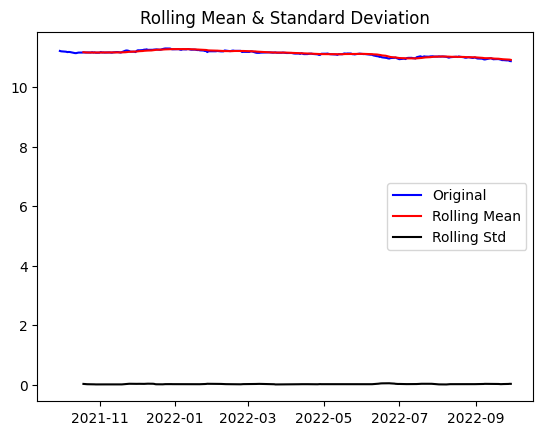

Results of Dickey-Fuller Test:
Test Statistic                   0.135770
p-value                          0.968420
#Lags Used                       0.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)


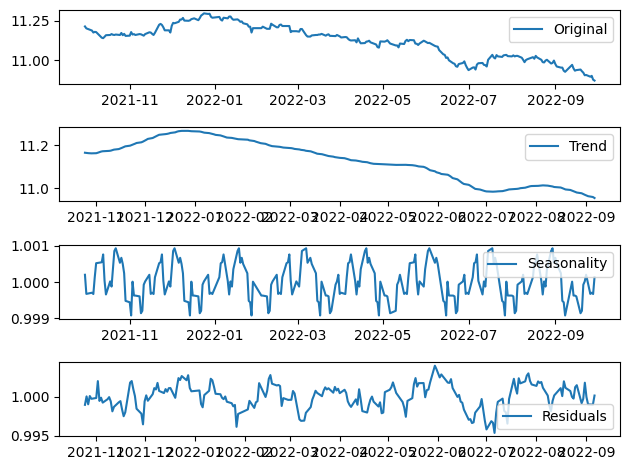

In [7]:

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [8]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.466086
p-value                          0.000002
#Lags Used                       1.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


STEP 4 : 학습, 테스트 데이터셋 생성

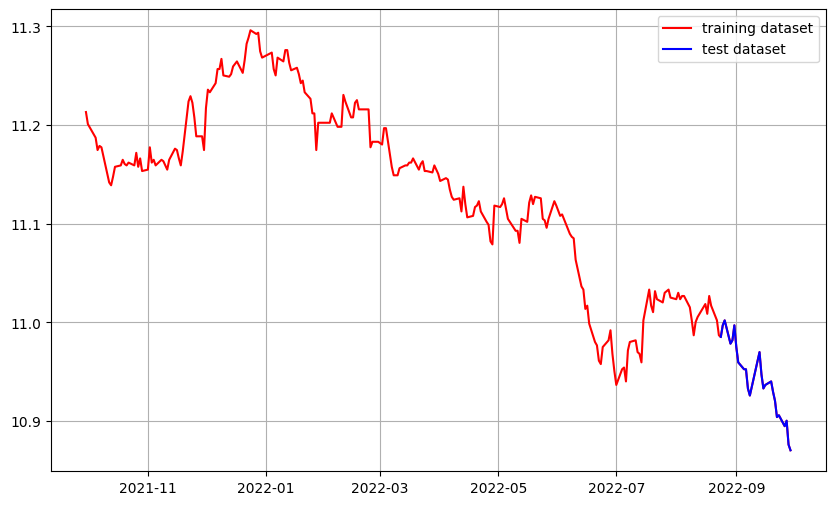

In [9]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

STEP 5 : 적정 ARIMA 모수 찾기

/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


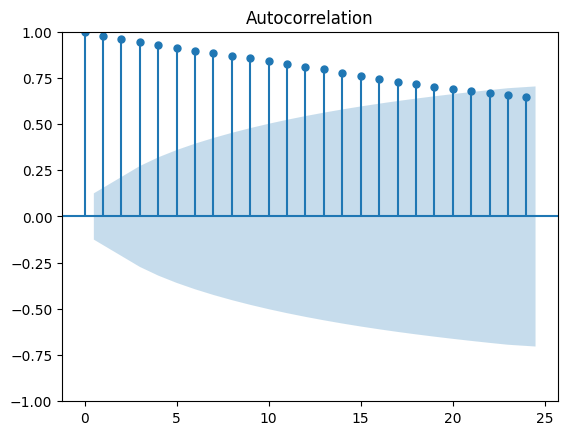

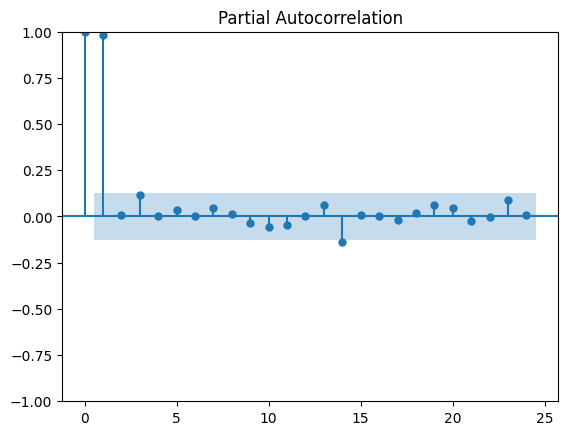

In [10]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.219244e+01
p-value                        1.276637e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.000473e+01
p-value                        1.844342e-17
#Lags Used                     8.000000e+00
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


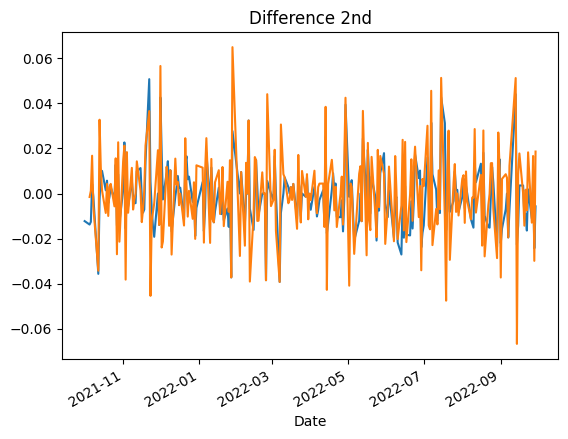

In [11]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

STEP 6 : ARIMA 모델 훈련과 테스트

In [12]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 634.104
Date:                Fri, 30 Sep 2022   AIC                          -1258.208
Time:                        13:03:00   BIC                          -1241.240
Sample:                             0   HQIC                         -1251.356
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1277      0.104    107.131      0.000      10.924      11.331
ar.L1          0.1056      3.556      0.030      0.976      -6.864       7.075
ar.L2          0.8813      3.536      0.249      0.8

/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


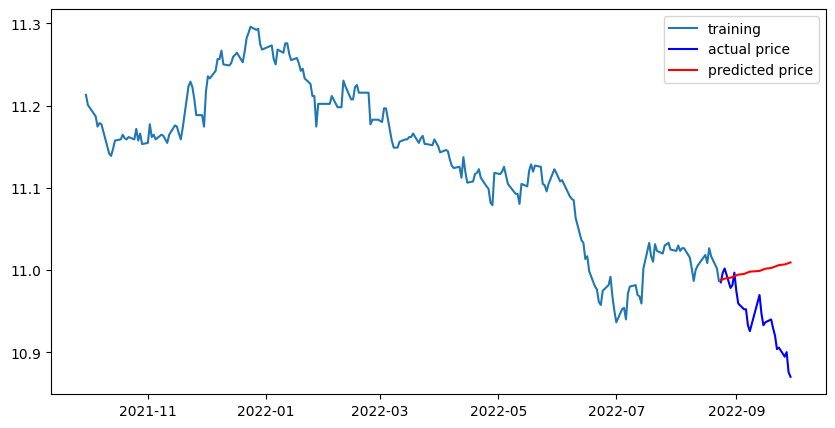

In [13]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  16462305.016222177
MAE:  3350.361659192094
RMSE:  4057.3766174983284
MAPE: 6.08%


STEP 7 : 다른 주식 종목 예측해 보기

화성산업(002460) 종목으로 테스트를 진행함.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2021-09-30 to 2022-09-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       245 non-null    float64
 1   High       245 non-null    float64
 2   Low        245 non-null    float64
 3   Close      245 non-null    float64
 4   Adj Close  245 non-null    float64
 5   Volume     245 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.4 KB
None


<AxesSubplot:xlabel='Date'>

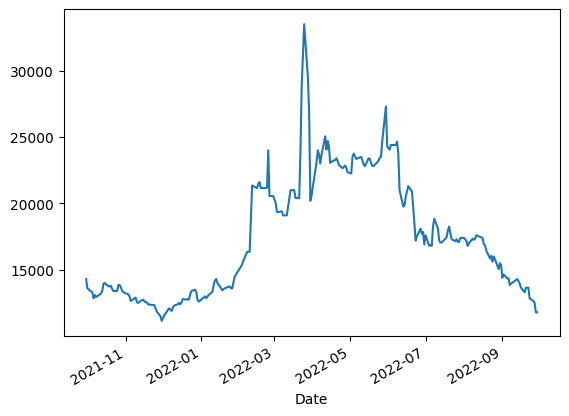

In [15]:

# Time Series 생성
dataset_filepath2 = './data/002460.KS.csv'
df2 = pd.read_csv(dataset_filepath2, index_col='Date', parse_dates=True)
ts2 = df2['Close']

print(df2.info())
ts2.head()
ts2.plot()

In [68]:
# 결측치 처리
ts2 = ts2.interpolate(method='time')
ts2[ts2.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [16]:
# 로그 변환 시도 
ts_log2 = np.log(ts2)

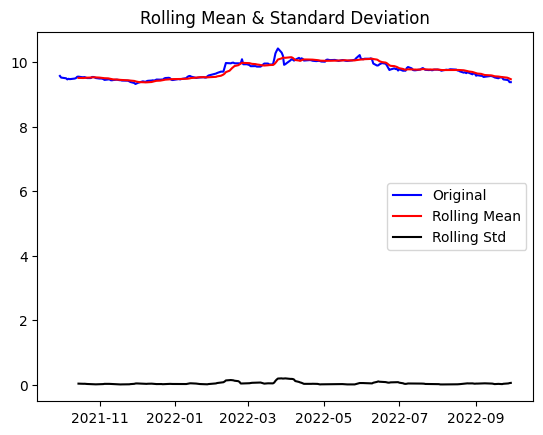

Results of Dickey-Fuller Test:
Test Statistic                  -0.968900
p-value                          0.764438
#Lags Used                       4.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


In [17]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log2, window=10)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log2)


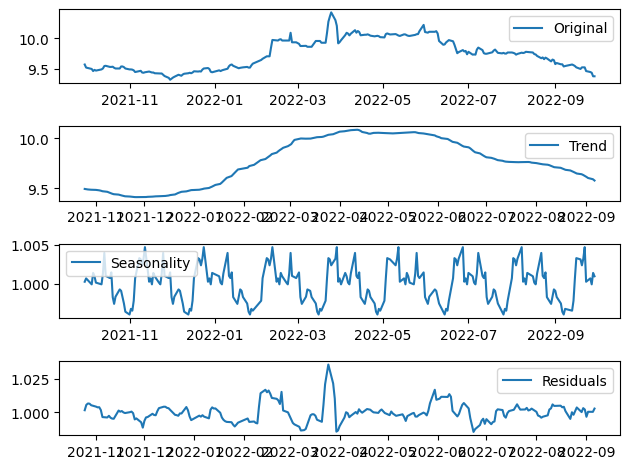

In [18]:

#시계열 분해 (Time Series Decomposition)
# from statsmodels.tsa.seasonal import seasonal_decompose
decomposition2 = seasonal_decompose(ts_log2, model='multiplicative', period = 30) 
trend2 = decomposition2.trend
seasonal2 = decomposition2.seasonal
residual2 = decomposition2.resid

plt.subplot(411)
plt.plot(ts_log2, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [19]:
# Residual 안정성 확인
residual2.dropna(inplace=True)
augmented_dickey_fuller_test(residual2)

Results of Dickey-Fuller Test:
Test Statistic                -5.756819e+00
p-value                        5.793971e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.050000e+02
Critical Value (1%)           -3.462658e+00
Critical Value (5%)           -2.875744e+00
Critical Value (10%)          -2.574341e+00
dtype: float64


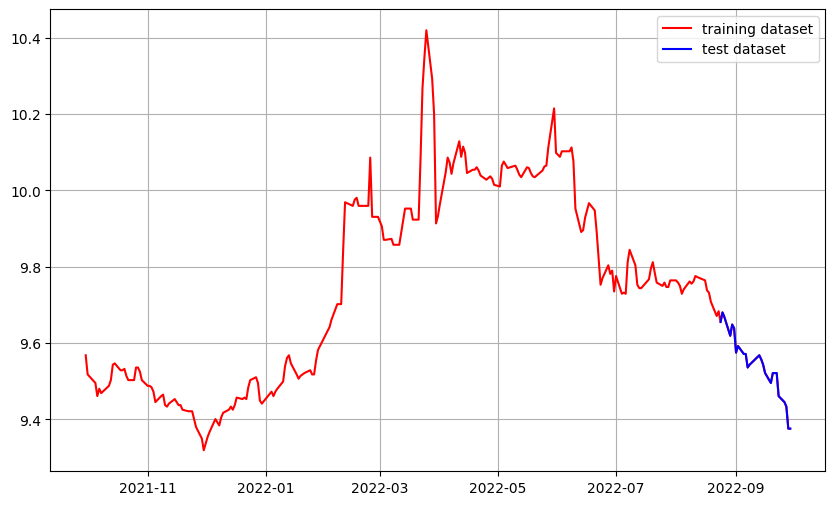

In [20]:
train_data2, test_data2 = ts_log2[:int(len(ts_log2)*0.9)], ts_log2[int(len(ts_log2)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log2, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data2, c='b', label='test dataset')
plt.legend()

/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


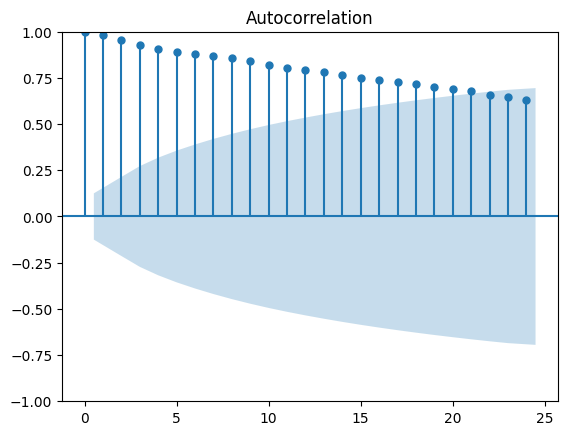

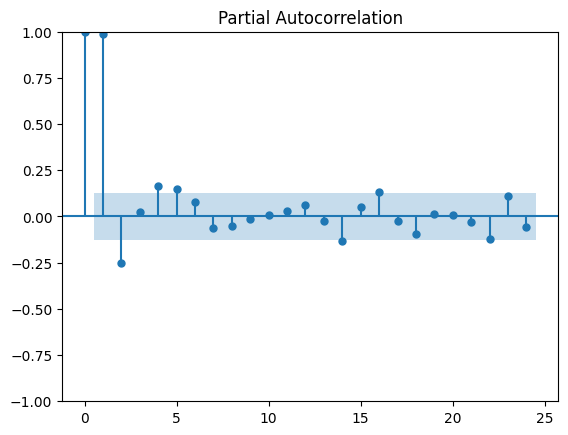

In [21]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.672471e+00
p-value                        1.266115e-16
#Lags Used                     3.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.818500e+00
p-value                        2.030097e-09
#Lags Used                     1.500000e+01
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64


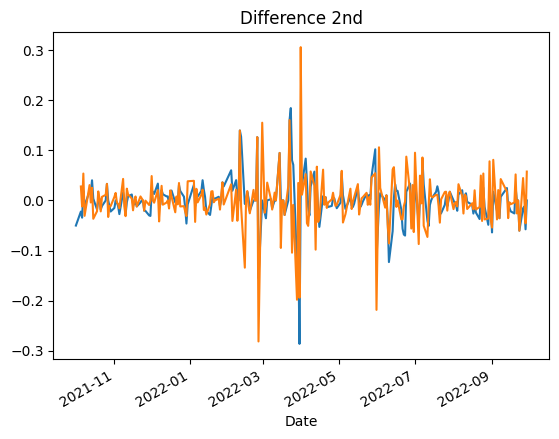

In [76]:
# 1차 차분 구하기
diff_12 = ts_log2.diff(periods=1).iloc[1:]
diff_12.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_12)

# 혹시 필요한 경우 2차 차분 구하기
diff_22 = diff_12.diff(periods=1).iloc[1:]
diff_22.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_22)

In [22]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model2 = ARIMA(train_data2, order=(2, 0, 1))  
fitted_m2 = model2.fit() 

print(fitted_m2.summary())

/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 383.592
Date:                Fri, 30 Sep 2022   AIC                           -757.185
Time:                        13:03:50   BIC                           -740.217
Sample:                             0   HQIC                          -750.332
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7265      0.208     46.729      0.000       9.319      10.134
ar.L1          1.2473      0.201      6.211      0.000       0.854       1.641
ar.L2         -0.2678      0.197     -1.357      0.1

/home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


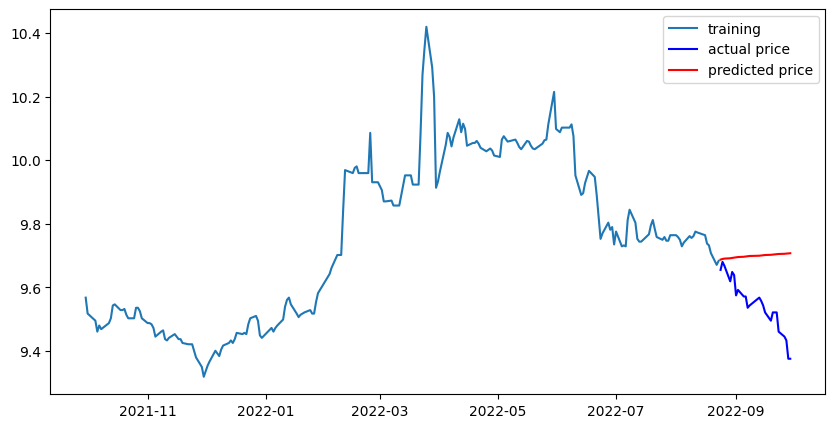

In [23]:
# Forecast : 결과가 fc에 담깁니다. 
fc2 = fitted_m2.forecast(len(test_data2), alpha=0.05)  # 95% conf
fc2 = np.array(fc2)
# Make as pandas series
fc_series2 = pd.Series(fc2, index=test_data2.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data2, label='training')
plt.plot(test_data2, c='b', label='actual price')
plt.plot(fc_series2, c='r',label='predicted price')
plt.legend()
plt.show()


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse2 = mean_squared_error(np.exp(test_data2), np.exp(fc2))
print('MSE: ', mse2)

mae2 = mean_absolute_error(np.exp(test_data2), np.exp(fc2))
print('MAE: ', mae2)

rmse2 = math.sqrt(mean_squared_error(np.exp(test_data2), np.exp(fc2)))
print('RMSE: ', rmse2)

mape2 = np.mean(np.abs(np.exp(fc2) - np.exp(test_data2))/np.abs(np.exp(test_data2)))
print('MAPE: {:.2f}%'.format(mape2*100))

MSE:  6650396.616874659
MAE:  2271.967700392417
RMSE:  2578.8362912125035
MAPE: 17.02%


---
STEP 8 : 회고  
<br />
 - 시계열 데이터에 대한 분석 및 모델링에 대하여 알아보는 시간이었는데, 왜 ARIMA모델이 statsmodels 패키지에 포함되었는지 이해할 수 있었다.
 - 시계열 데이터에서 trend, seasonality, residual 특성과 그에 따른 설정 모수 p,q,d는 제어할때 closed loop에서 pid(비례, 적분, 미분) 설정과 비슷해 보였다.
 - ADFT를 통한 p-value안정성 확인과, ACF, PACF를 통하여 p,q설정, 차분을 이용한 i설정등을 배웠으나, ARIMA학습 결과표에 대한 이해가 부족했다.
 - 예측 불가한 주식에서 seasonality가 주기적인 모양을 뚜렷히 나타내었지만 <b>예측치는 결과와 큰 차이를 보였다.</b>